In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
plt.style.use('ggplot')

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score, r2_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from pprint import pprint

In [61]:
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant

### Functions

In [45]:
def modelfit(classifier, X_train,y_train, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    classifier.fit(X_train, y_train)
        
    #Predict training set:
    predictions = classifier.predict(X_train)
    predprob = classifier.predict_proba(X_train)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(classifier, X_train, y_train, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print("\nModel Report")
    print("Recall (Train) : %.4g" % recall_score(y_train, predictions))
    print("AUC Score (Train): %f" % roc_auc_score(y_train, predprob))
    
#     print("Accuracy (Test) : %.4g" % metrics.accuracy_score(y_train, predictions))
#     print("AUC Score (Test): %f" % metrics.roc_auc_score(y_train, predprob))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(classifier.feature_importances_, X_train.columns).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

In [5]:
def get_scores(classifier, X_train, X_test, y_train, y_test, color = 'navy', **kwargs):
    model = classifier(**kwargs)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    y_predict_train = model.predict(X_train)
    y_probas = model.predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_probas[:,1]) #take probas of positive class
    
    train_acc = accuracy_score(y_train, y_predict_train)
    test_acc = accuracy_score(y_test, y_predict)
    pre = precision_score(y_test, y_predict)
    re = recall_score(y_test, y_predict)
   
    roc_auc = auc(fpr, tpr)
    
    model_name = type(model).__name__
    
    lw = 2
    plt.plot(fpr, tpr, color=color,
             lw=lw, label='{0} - AUC = {1:0.2f}'.format(model_name, roc_auc)
            )
    
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC')
    plt.legend(loc="lower right")
    plt.show()
    
     
    if model_name == 'RandomForestClassifier':
        oob = model.oob_score_
        return 'Train Accuracy: {0:0.2f}. Test Accuracy: {1:0.2f}. OOB: {2:0.2f}. Precision: {3:0.2f}. Recall: {4:0.2f}. AUC: {5:0.2f}'.format(train_acc, test_acc, oob, pre, re, roc_auc)    
    
    else:
        return 'Train Accuracy: {0:0.2f}. Test Accuracy: {1:0.2f}. Precision: {2:0.2f}. Recall: {3:0.2f}. AUC: {4:0.2f}'.format(train_acc, test_acc, pre, re, roc_auc)
           


In [6]:
def feature_importance(classifier, X_train, X_test, y_train, y_test, color ='red', **kwargs):
    model = classifier(**kwargs)
    model.fit(X_train, y_train)
    
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    cols = []
    values = []
    for f in range(25):

        idx = indices[f]
        col = X_train.columns[idx]
        value = importances[idx]
        cols.append(col)
        values.append(value)
   
    model_name = type(model).__name__

    fig, ax = plt.subplots()
    y_pos = np.arange(len(cols))
    ax.barh(y_pos, values,
            color=color, align="center")
    ax.set_yticks(y_pos)
    ax.set_yticklabels(cols)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Feature Importance')
    ax.set_title('{0} - Top 25 features'.format(model_name))

    plt.show()

In [7]:
df = pd.read_csv('data/presentation_outcomes_dataset_for_modeling.csv',index_col =0)

In [8]:
click_cols = ['all_click_dataplus',
'all_click_dualpane',
'all_click_externalquiz',
'all_click_folder',
'all_click_forumng',
'all_click_glossary',
'all_click_homepage',
'all_click_htmlactivity',
'all_click_oucollaborate',
'all_click_oucontent',
'all_click_ouelluminate',
'all_click_ouwiki',
'all_click_page',
'all_click_questionnaire',
'all_click_quiz',
'all_click_repeatactivity',
'all_click_resource',
'all_click_sharedsubpage',
'all_click_subpage',
'all_click_url',
'all_click_total_num_vle_actions']
              

In [9]:
df = df.drop(click_cols,axis = 1)

In [10]:
str_cols = '''early_days_dataplus
early_days_dualpane
early_days_externalquiz
early_days_forumng
early_days_glossary
early_days_homepage
early_days_htmlactivity
early_days_oucollaborate
early_days_oucontent
early_days_ouelluminate
early_days_ouwiki
early_days_page
early_days_questionnaire
early_days_quiz
early_days_resource
early_days_sharedsubpage
early_days_subpage
early_days_url
early_days_total_num_vle_days
early_click_dataplus
early_click_dualpane
early_click_externalquiz
early_click_forumng
early_click_glossary
early_click_homepage
early_click_htmlactivity
early_click_oucollaborate
early_click_oucontent
early_click_ouelluminate
early_click_ouwiki
early_click_page
early_click_questionnaire
early_click_quiz
early_click_resource
early_click_sharedsubpage
early_click_subpage
early_click_url
early_click_total_num_vle_actions
'''
str_cols = str_cols.split('\n')
str_cols.remove('')

In [220]:
str_cols

['early_days_dataplus',
 'early_days_dualpane',
 'early_days_externalquiz',
 'early_days_forumng',
 'early_days_glossary',
 'early_days_homepage',
 'early_days_htmlactivity',
 'early_days_oucollaborate',
 'early_days_oucontent',
 'early_days_ouelluminate',
 'early_days_ouwiki',
 'early_days_page',
 'early_days_questionnaire',
 'early_days_quiz',
 'early_days_resource',
 'early_days_sharedsubpage',
 'early_days_subpage',
 'early_days_url',
 'early_days_total_num_vle_days',
 'early_click_dataplus',
 'early_click_dualpane',
 'early_click_externalquiz',
 'early_click_forumng',
 'early_click_glossary',
 'early_click_homepage',
 'early_click_htmlactivity',
 'early_click_oucollaborate',
 'early_click_oucontent',
 'early_click_ouelluminate',
 'early_click_ouwiki',
 'early_click_page',
 'early_click_questionnaire',
 'early_click_quiz',
 'early_click_resource',
 'early_click_sharedsubpage',
 'early_click_subpage',
 'early_click_url',
 'early_click_total_num_vle_actions']

In [11]:
df_no_w = df.drop(str_cols,axis = 1)

# Modeling - Predicting for students who are registered as of Day 0

In [12]:
df_no_w = df_no_w[(df_no_w.date_unregistration>=0) | (df_no_w.date_unregistration.isna())]

### Train Test Split - use aggressive amount for Test since sample size is >30k

In [13]:
df_no_w.shape

(29915, 81)

In [14]:
df_no_w = df_no_w.drop(['final_result', 'code_module', 'code_presentation', 'id_student', 'courses_date_time'], axis = 1)

In [15]:
df_no_w

,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,module_presentation,final_result_edit,...,before_days_ouelluminate,before_days_ouwiki,before_days_page,before_days_questionnaire,before_days_quiz,before_days_resource,before_days_sharedsubpage,before_days_subpage,before_days_url,before_days_total_num_vle_days
0,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,AAA-2013J,Pass,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0
1,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,AAA-2013J,Pass,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,9.0,5.0,44.0
2,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,AAA-2013J,Fail,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,6.0,1.0,29.0
3,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,AAA-2013J,Pass,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,6.0,3.0,33.0
4,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,AAA-2013J,Pass,...,0.0,0.0,0.0,0.0,0.0,7.0,0.0,10.0,2.0,58.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32588,F,Wales,Lower Than A Level,10-20,0-35,0,30,N,GGG-2014J,Fail,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
32589,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,GGG-2014J,Pass,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32590,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,GGG-2014J,Pass,...,0.0,0.0,0.0,0.0,1.0,3.0,0.0,1.0,0.0,7.0
32591,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,GGG-2014J,Fail,...,0.0,0.0,0.0,0.0,0.0,7.0,0.0,2.0,0.0,17.0


In [16]:
df_no_w.age_band.unique()

array(['55<=', '35-55', '0-35'], dtype=object)

In [17]:
df_no_w["highest_education"] = df_no_w["highest_education"].map({np.nan: 0, 'No Formal quals': 1, "Lower Than A Level": 2,
                                                            "A Level or Equivalent": 3, 'HE Qualification': 4, 'Post Graduate Qualification': 5}).astype(int)

In [18]:
df_no_w["imd_band"] = df_no_w["imd_band"].map({'0': 0, '0-10%': 1, '10-20': 2,
                                            '20-30%': 3, '30-40%': 4, '40-50%': 5,
                                            '50-60%': 6, '60-70%': 7, '70-80%': 8,
                                            '80-90%': 9, '90-100%': 10
                                              }).astype(int)

In [19]:
df_no_w["age_band"] = df_no_w["age_band"].map({'0-35': 0, '35-55': 1, '55<=': 2
                                              }).astype(int)

In [20]:
df_no_w["disability"]= df_no_w["disability"].map({'Y': 1, 'N': 0
                                              }).astype(int)

In [21]:
df_no_w["gender"]= df_no_w["gender"].map({'M': 1, 'F': 0
                                              }).astype(int)

In [22]:
df_no_w["final_result_edit"]= df_no_w["final_result_edit"].map({'Fail': 1, 'Pass': 0
                                              }).astype(int)

In [23]:
df_no_w.rename(columns = {'final_result_edit' : 'fail_flag'}, inplace = True)

In [24]:
df_no_w.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 29915 entries, 0 to 32592
Data columns (total 76 columns):
gender                                29915 non-null int64
region                                29915 non-null object
highest_education                     29915 non-null int64
imd_band                              29915 non-null int64
age_band                              29915 non-null int64
num_of_prev_attempts                  29915 non-null int64
studied_credits                       29915 non-null int64
disability                            29915 non-null int64
module_presentation                   29915 non-null object
fail_flag                             29915 non-null int64
courses_module_presentation_length    29915 non-null int64
num_assessments                       29915 non-null int64
num_tma_assessments                   29915 non-null int64
num_cma_assessments                   29915 non-null int64
num_exam_assessments                  29915 non-null int64
vle_

In [25]:
df_no_w = pd.get_dummies(df_no_w)

In [26]:
# Dummy Vars
'''
region_East Anglian Region
region_East Midlands Region
region_Ireland
region_London Region
region_North Region
region_North Western Region
region_Scotland
region_South East Region
region_South Region
region_South West Region
region_Wales
region_West Midlands Region
region_Yorkshire Region

module_presentation_AAA-2013J
module_presentation_AAA-2014J
module_presentation_BBB-2013B
module_presentation_BBB-2013J
module_presentation_BBB-2014B
module_presentation_BBB-2014J
module_presentation_CCC-2014B
module_presentation_CCC-2014J
module_presentation_DDD-2013B
module_presentation_DDD-2013J
module_presentation_DDD-2014B
module_presentation_DDD-2014J
module_presentation_EEE-2013J
module_presentation_EEE-2014B
module_presentation_EEE-2014J
module_presentation_FFF-2013B
module_presentation_FFF-2013J
module_presentation_FFF-2014B
module_presentation_FFF-2014J
module_presentation_GGG-2013J
module_presentation_GGG-2014B
module_presentation_GGG-2014J'''

'\nregion_East Anglian Region\nregion_East Midlands Region\nregion_Ireland\nregion_London Region\nregion_North Region\nregion_North Western Region\nregion_Scotland\nregion_South East Region\nregion_South Region\nregion_South West Region\nregion_Wales\nregion_West Midlands Region\nregion_Yorkshire Region\n\nmodule_presentation_AAA-2013J\nmodule_presentation_AAA-2014J\nmodule_presentation_BBB-2013B\nmodule_presentation_BBB-2013J\nmodule_presentation_BBB-2014B\nmodule_presentation_BBB-2014J\nmodule_presentation_CCC-2014B\nmodule_presentation_CCC-2014J\nmodule_presentation_DDD-2013B\nmodule_presentation_DDD-2013J\nmodule_presentation_DDD-2014B\nmodule_presentation_DDD-2014J\nmodule_presentation_EEE-2013J\nmodule_presentation_EEE-2014B\nmodule_presentation_EEE-2014J\nmodule_presentation_FFF-2013B\nmodule_presentation_FFF-2013J\nmodule_presentation_FFF-2014B\nmodule_presentation_FFF-2014J\nmodule_presentation_GGG-2013J\nmodule_presentation_GGG-2014B\nmodule_presentation_GGG-2014J'

In [27]:
df_no_w = df_no_w.drop(['date_unregistration'],axis = 1)
y = df_no_w.pop('fail_flag')
X = df_no_w
X = X.fillna(0)

In [28]:
X_exclude_one_dummy = X.drop(['module_presentation_AAA-2013J','module_presentation_AAA-2014J','region_London Region'], axis = 1)

In [135]:
y.value_counts() / len(y)


0    0.51429
1    0.48571
Name: fail_flag, dtype: float64

In [227]:
### Testing at EOD

# df = pd.read_csv('data/dataset_for_modeling_day_zero.csv',index_col =0)
df = pd.read_csv('data/dataset_for_modeling_day_twelve.csv',index_col =0)

y = df.pop('fail_flag')
X = df
X = X.fillna(0)

In [223]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, test_size = 0.25, random_state = 42)

In [30]:
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_exclude_one_dummy, y, shuffle = True, test_size = 0.25, random_state = 42)

In [31]:
X_train.shape

(22436, 107)

In [32]:
X_train_l.shape

(22436, 104)

In [33]:
model_l = LogisticRegression()

In [46]:
modelfit(model_l, X_train_l,y_train_l, performCV=True, printFeatureImportance=False, cv_folds=5);

/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: Con


Model Report
Recall (Train) : 0.6552
AUC Score (Train): 0.749422
CV Score : Mean - 0.7448053 | Std - 0.003579652 | Min - 0.7378733 | Max - 0.747903


In [56]:
logit_cols = """gender
highest_education
imd_band
age_band"""

# num_of_prev_attempts
# studied_credits
# disability

In [59]:
logit_cols = logit_cols.split('\n')

In [103]:
logit_cols_2 = """gender
highest_education
imd_band
age_band
num_of_prev_attempts
studied_credits
disability"""
logit_cols_2 = logit_cols_2.split('\n')

In [63]:
X_l = X_train_l[logit_cols].values
X_const_l = add_constant(X_l, prepend=True)
y_l = y_train_l.values

logit_model = Logit(y_l, X_const_l).fit()

Optimization terminated successfully.
         Current function value: 0.674785
         Iterations 4


In [95]:
logit_model.summary(yname = 'Fail_Flag', xname =  ['const'] + list(X_train_l[logit_cols].columns) \
                   )


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Fail_Flag   No. Observations:                22436
Model:                          Logit   Df Residuals:                    22431
Method:                           MLE   Df Model:                            4
Date:                Thu, 14 May 2020   Pseudo R-squ.:                 0.02588
Time:                        17:21:02   Log-Likelihood:                -15139.
converged:                       True   LL-Null:                       -15542.
Covariance Type:            nonrobust   LLR p-value:                9.086e-173
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.2803      0.057     22.352      0.000       1.168       1.393
gender                0.1926      0.027      7.011      0.000       0.139       0.246
highest_education    -0.3906      0.019    -20.939      0.000      -0.427      -0.354
imd_band             -0.0606      0.005    -12.889      0.000      -0.070      -0.051
age_band             -0.2334      0.029     -8.045      0.000      -0.290      -0.177
=====================================================================================
"""

In [104]:
X_l = X_train_l[logit_cols_2].values
X_const_l = add_constant(X_l, prepend=True)
y_l = y_train_l.values

logit_model = Logit(y_l, X_const_l).fit()

Optimization terminated successfully.
         Current function value: 0.665216
         Iterations 5


In [105]:
logit_model.summary(yname = 'Fail_Flag', xname =  ['const'] + list(X_train_l[logit_cols_2].columns) \
                   )


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Fail_Flag   No. Observations:                22436
Model:                          Logit   Df Residuals:                    22428
Method:                           MLE   Df Model:                            7
Date:                Thu, 14 May 2020   Pseudo R-squ.:                 0.03969
Time:                        17:30:21   Log-Likelihood:                -14925.
converged:                       True   LL-Null:                       -15542.
Covariance Type:            nonrobust   LLR p-value:                3.688e-262
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.8260      0.064     12.927      0.000       0.701       0.951
gender                   0.1998      0.028      7.197      0.000       0.145       0.254
highest_education       -0.3872      0.019    -20.492      0.000      -0.424      -0.350
imd_band                -0.0573      0.005    -12.071      0.000      -0.067      -0.048
age_band                -0.2085      0.029     -7.088      0.000      -0.266      -0.151
num_of_prev_attempts     0.4142      0.032     12.863      0.000       0.351       0.477
studied_credits          0.0042      0.000     11.518      0.000       0.004       0.005
disability               0.2631      0.047      5.558      0.000       0.170       0.356
========================================================================================
"""

In [106]:
logit_cols_3 = """gender
highest_education
imd_band
age_band
num_of_prev_attempts
studied_credits
disability
date_registration"""
logit_cols_3 = logit_cols_3.split('\n')

In [107]:
X_l = X_train_l[logit_cols_3].values
X_const_l = add_constant(X_l, prepend=True)
y_l = y_train_l.values

logit_model = Logit(y_l, X_const_l).fit()
logit_model.summary(yname = 'Fail_Flag', xname =  ['const'] + list(X_train_l[logit_cols_3].columns) \
                   )


Optimization terminated successfully.
         Current function value: 0.665157
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Fail_Flag   No. Observations:                22436
Model:                          Logit   Df Residuals:                    22427
Method:                           MLE   Df Model:                            8
Date:                Thu, 14 May 2020   Pseudo R-squ.:                 0.03977
Time:                        17:32:24   Log-Likelihood:                -14923.
converged:                       True   LL-Null:                       -15542.
Covariance Type:            nonrobust   LLR p-value:                1.357e-261
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.8586      0.067     12.818      0.000       0.727       0.990
gender                   0.2008      0.028      7.232      0.000       0.146       0.255
highest_education       -0.3887      0.019    -20.545      0.000      -0.426      -0.352
imd_band                -0.0573      0.005    -12.073      0.000      -0.067      -0.048
age_band                -0.2097      0.029     -7.126      0.000      -0.267      -0.152
num_of_prev_attempts     0.4148      0.032     12.878      0.000       0.352       0.478
studied_credits          0.0043      0.000     11.587      0.000       0.004       0.005
disability               0.2633      0.047      5.561      0.000       0.170       0.356
date_registration        0.0005      0.000      1.628      0.104   -9.57e-05       0.001
========================================================================================
"""

In [118]:
logit_cols_4 = """gender
highest_education
imd_band
age_band
num_of_prev_attempts
studied_credits
disability
date_registration
num_assessments
num_tma_assessments
num_cma_assessments
region_East Anglian Region
region_East Midlands Region
region_Ireland
region_North Region
region_North Western Region
region_Scotland
region_South East Region
region_South Region
region_South West Region
region_Wales
region_West Midlands Region
region_Yorkshire Region"""
logit_cols_4 = logit_cols_4.split('\n')

X_l = X_train_l[logit_cols_4].values
X_const_l = add_constant(X_l, prepend=True)
y_l = y_train_l.values

logit_model = Logit(y_l, X_const_l).fit()
logit_model.summary(yname = 'Fail_Flag', xname =  ['const'] + list(X_train_l[logit_cols_4].columns) \
                   )


Optimization terminated successfully.
         Current function value: 0.656476
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Fail_Flag   No. Observations:                22436
Model:                          Logit   Df Residuals:                    22412
Method:                           MLE   Df Model:                           23
Date:                Thu, 14 May 2020   Pseudo R-squ.:                 0.05231
Time:                        17:35:55   Log-Likelihood:                -14729.
converged:                       True   LL-Null:                       -15542.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -0.3853      0.130     -2.960      0.003      -0.640      -0.130
gender                          0.1754      0.029      6.140      0.000       0.119       0.231
highest_education              -0.4403      0.020    -22.318      0.000      -0.479      -0.402
imd_band                       -0.0572      0.005    -10.987      0.000      -0.067      -0.047
age_band                       -0.2119      0.030     -7.127      0.000      -0.270      -0.154
num_of_prev_attempts            0.4236      0.033     12.968      0.000       0.360       0.488
studied_credits                 0.0033      0.000      8.530      0.000       0.003       0.004
disability                      0.2657      0.048      5.533      0.000       0.172       0.360
date_registration               0.0009      0.000      2.888      0.004       0.000       0.001
num_assessments                 0.7473      0.046     16.269      0.000       0.657       0.837
num_tma_assessments            -0.5859      0.042    -13.910      0.000      -0.668      -0.503
num_cma_assessments            -0.7453      0.046    -16.139      0.000      -0.836      -0.655
region_East Anglian Region     -0.2291      0.063     -3.623      0.000      -0.353      -0.105
region_East Midlands Region    -0.1071      0.068     -1.566      0.117      -0.241       0.027
region_Ireland                 -0.4051      0.084     -4.805      0.000      -0.570      -0.240
region_North Region            -0.4866      0.074     -6.598      0.000      -0.631      -0.342
region_North Western Region     0.0226      0.064      0.350      0.726      -0.104       0.149
region_Scotland                -0.0349      0.062     -0.563      0.573      -0.156       0.087
region_South East Region       -0.3116      0.071     -4.366      0.000      -0.451      -0.172
region_South Region            -0.2520      0.065     -3.895      0.000      -0.379      -0.125
region_South West Region       -0.2918      0.067     -4.340      0.000      -0.424      -0.160
region_Wales                    0.0102      0.070      0.146      0.884      -0.127       0.147
region_West Midlands Region    -0.1136      0.067     -1.702      0.089      -0.244       0.017
region_Yorkshire Region        -0.1526      0.070     -2.165      0.030      -0.291      -0.014
===============================================================================================
"""

In [119]:
logit_cols_4 = """gender
highest_education
imd_band
age_band
num_of_prev_attempts
studied_credits
disability
date_registration
num_assessments
num_tma_assessments
num_cma_assessments
region_East Anglian Region
region_Ireland
region_North Region
region_South East Region
region_South Region
region_South West Region
region_Yorkshire Region
module_presentation_BBB-2013B
module_presentation_BBB-2013J
module_presentation_BBB-2014B
module_presentation_BBB-2014J
module_presentation_CCC-2014B
module_presentation_CCC-2014J
module_presentation_DDD-2013B
module_presentation_DDD-2013J
module_presentation_DDD-2014B
module_presentation_DDD-2014J
module_presentation_EEE-2013J
module_presentation_EEE-2014B
module_presentation_EEE-2014J
module_presentation_FFF-2013B
module_presentation_FFF-2013J
module_presentation_FFF-2014B
module_presentation_FFF-2014J
module_presentation_GGG-2013J
module_presentation_GGG-2014B
module_presentation_GGG-2014J"""
logit_cols_4 = logit_cols_4.split('\n')

X_l = X_train_l[logit_cols_4].values
X_const_l = add_constant(X_l, prepend=True)
y_l = y_train_l.values

logit_model = Logit(y_l, X_const_l).fit()
logit_model.summary(yname = 'Fail_Flag', xname =  ['const'] + list(X_train_l[logit_cols_4].columns) \
                   )


Optimization terminated successfully.
         Current function value: 0.653680
         Iterations 32


/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Fail_Flag   No. Observations:                22436
Model:                          Logit   Df Residuals:                    22400
Method:                           MLE   Df Model:                           35
Date:                Thu, 14 May 2020   Pseudo R-squ.:                 0.05634
Time:                        17:37:05   Log-Likelihood:                -14666.
converged:                       True   LL-Null:                       -15542.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -0.1614        nan        nan        nan         nan         nan
gender                            0.0968      0.035      2.764      0.006       0.028       0.165
highest_education                -0.4446      0.020    -22.617      0.000      -0.483      -0.406
imd_band                         -0.0580      0.005    -11.226      0.000      -0.068      -0.048
age_band                         -0.1803      0.030     -6.004      0.000      -0.239      -0.121
num_of_prev_attempts              0.4094      0.033     12.506      0.000       0.345       0.474
studied_credits                   0.0036      0.000      9.088      0.000       0.003       0.004
disability                        0.2470      0.048      5.127      0.000       0.153       0.341
date_registration                 0.0008      0.000      2.821      0.005       0.000       0.001
num_assessments                   0.3470        nan        nan        nan         nan         nan
num_tma_assessments              -0.2539   2.24e+05  -1.14e-06      1.000   -4.38e+05    4.38e+05
num_cma_assessments              -0.2528    1.6e+05  -1.58e-06      1.000   -3.14e+05    3.14e+05
region_East Anglian Region       -0.1959      0.049     -4.005      0.000      -0.292      -0.100
region_Ireland                   -0.3472      0.075     -4.621      0.000      -0.494      -0.200
region_North Region              -0.4777      0.063     -7.575      0.000      -0.601      -0.354
region_South East Region         -0.2694      0.059     -4.550      0.000      -0.385      -0.153
region_South Region              -0.2198      0.051     -4.344      0.000      -0.319      -0.121
region_South West Region         -0.2657      0.054     -4.897      0.000      -0.372      -0.159
region_Yorkshire Region          -0.1160      0.059     -1.977      0.048      -0.231      -0.001
module_presentation_BBB-2013B     0.1062        nan        nan        nan         nan         nan
module_presentation_BBB-2013J    -0.1187        nan        nan        nan         nan         nan
module_presentation_BBB-2014B    -0.1670        nan        nan        nan         nan         nan
module_presentation_BBB-2014J     0.3854      0.112      3.448      0.001       0.166       0.605
module_presentation_CCC-2014B     0.6075   8.48e+05   7.16e-07      1.000   -1.66e+06    1.66e+06
module_presentation_CCC-2014J     0.4075   8.48e+05    4.8e-07      1.000   -1.66e+06    1.66e+06
module_presentation_DDD-2013B     0.2776        nan        nan        nan         nan         nan
module_presentation_DDD-2013J     0.7063        nan        nan        nan         nan         nan
module_presentation_DDD-2014B     0.8631        nan        nan        nan         nan         nan
module_presentation_DDD-2014J     0.6668        nan        nan        nan         nan         nan
module_presentation_EEE-2013J     0.4239        nan        nan        nan         nan         nan
module_

In [126]:
logit_cols_4 = """gender
highest_education
imd_band
age_band
num_of_prev_attempts
studied_credits
disability
date_registration
num_assessments
region_East Anglian Region
region_Ireland
region_North Region
region_South East Region
region_South Region
region_South West Region
region_Yorkshire Region
module_presentation_BBB-2013B
module_presentation_BBB-2013J
module_presentation_BBB-2014B
module_presentation_BBB-2014J
vle_dataplus
vle_dualpane
vle_externalquiz
vle_folder
vle_forumng
vle_glossary
vle_homepage
vle_htmlactivity
vle_oucollaborate
vle_oucontent
vle_ouelluminate
vle_ouwiki
vle_page
vle_questionnaire
vle_quiz
vle_repeatactivity
vle_resource
vle_sharedsubpage
vle_subpage
vle_url
vle_total_num_vle"""
logit_cols_4 = logit_cols_4.split('\n')

X_l = X_train_l[logit_cols_4].values
X_const_l = add_constant(X_l, prepend=True)
y_l = y_train_l.values

logit_model = Logit(y_l, X_const_l).fit()
logit_model.summary(yname = 'Fail_Flag'
                   )


         Current function value: 0.653676
         Iterations: 35


/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Fail_Flag   No. Observations:                22436
Model:                          Logit   Df Residuals:                    22399
Method:                           MLE   Df Model:                           36
Date:                Thu, 14 May 2020   Pseudo R-squ.:                 0.05635
Time:                        17:39:24   Log-Likelihood:                -14666.
converged:                      False   LL-Null:                       -15542.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0970      0.035      2.769      0.006       0.028       0.166
x2            -0.4446      0.020    -22.616      0.000      -0.483      -0.406
x3            -0.0580      0.005    -11.224      0.000      -0.068      -0.048
x4            -0.1803      0.030     -6.005      0.000      -0.239      -0.121
x5             0.4091      0.033     12.494      0.000       0.345       0.473
x6             0.0036      0.000      9.094      0.000       0.003       0.004
x7             0.2471      0.048      5.129      0.000       0.153       0.341
x8             0.0008      0.000      2.819      0.005       0.000       0.001
x9             0.3123   3.05e+04   1.02e-05      1.000   -5.99e+04    5.99e+04
x10           -0.1959      0.049     -4.003      0.000      -0.292      -0.100
x11           -0.3471      0.075     -4.619      0.000      -0.494      -0.200
x12           -0.4778      0.063     -7.575      0.000      -0.601      -0.354
x13           -0.2697      0.059     -4.555      0.000      -0.386      -0.154
x14           -0.2199      0.051     -4.346      0.000      -0.319      -0.121
x15           -0.2658      0.054     -4.899      0.000      -0.372      -0.159
x16           -0.1158      0.059     -1.975      0.048      -0.231      -0.001
x17            1.6491        nan        nan        nan         nan         nan
x18            0.8333        nan        nan        nan         nan         nan
x19            0.9221        nan        nan        nan         nan         nan
x20            0.3382   4.02e+05   8.41e-07      1.000   -7.88e+05    7.88e+05
x21           -0.1866   5.74e+04  -3.25e-06      1.000   -1.13e+05    1.13e+05
x22           -2.5663   3.83e+05  -6.71e-06      1.000    -7.5e+05     7.5e+05
x23            1.6503        nan        nan        nan         nan         nan
x24            1.5762        nan        nan        nan         nan         nan
x25           -0.0853        nan        nan        nan         nan         nan
x26            1.8794        nan        nan        nan         nan         nan
const         -6.4095        nan        nan        nan         nan         nan
x27            1.2914        nan        nan        nan         nan         nan
x28            0.3325   2451.701      0.000      1.000   -4804.914    4805.578
x29            0.0159   1594.976   9.98e-06      1.000   -3126.079    3126.111
x30            0.1416        nan        nan        nan         nan         nan
x31            0.3368   7278.800   4.63e-05      1.000   -1.43e+04    1.43e+04
x32            1.2724   1.02e+04      0.000      1.000   -1.99e+04       2e+04
x33           -0.8840        nan        nan        nan         nan         nan
x34            0.0597        nan        nan        nan         nan         nan
x35           -1.4826   2.89e+05  -5.14e-06      1.000   -5.66e+05    5.66e+05
x36           -0.0477    370.753     -0.000      1.000    -726.711     726.616
x37            3.4047        nan        nan        nan         nan         nan
x3

In [128]:
logit_cols_4 = """gender
highest_education
imd_band
age_band
num_of_prev_attempts
studied_credits
disability
date_registration
num_assessments
region_East Anglian Region
region_Ireland
region_North Region
region_South East Region
region_South Region
region_South West Region
region_Yorkshire Region
module_presentation_BBB-2013B
module_presentation_BBB-2013J
module_presentation_BBB-2014B
module_presentation_BBB-2014J
vle_total_num_vle"""
logit_cols_4 = logit_cols_4.split('\n')

X_l = X_train_l[logit_cols_4].values
X_const_l = add_constant(X_l, prepend=True)
y_l = y_train_l.values

logit_model = Logit(y_l, X_const_l).fit()
logit_model.summary(yname = 'Fail_Flag', xname =  ['const'] + list(X_train_l[logit_cols_4].columns)
                   )


Optimization terminated successfully.
         Current function value: 0.662009
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Fail_Flag   No. Observations:                22436
Model:                          Logit   Df Residuals:                    22414
Method:                           MLE   Df Model:                           21
Date:                Thu, 14 May 2020   Pseudo R-squ.:                 0.04432
Time:                        17:40:32   Log-Likelihood:                -14853.
converged:                       True   LL-Null:                       -15542.
Covariance Type:            nonrobust   LLR p-value:                5.939e-279
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             0.9643      0.090     10.774      0.000       0.789       1.140
gender                            0.1372      0.032      4.280      0.000       0.074       0.200
highest_education                -0.3972      0.019    -20.742      0.000      -0.435      -0.360
imd_band                         -0.0566      0.005    -11.064      0.000      -0.067      -0.047
age_band                         -0.2045      0.030     -6.911      0.000      -0.263      -0.147
num_of_prev_attempts              0.4079      0.032     12.575      0.000       0.344       0.472
studied_credits                   0.0041      0.000     10.625      0.000       0.003       0.005
disability                        0.2502      0.048      5.246      0.000       0.157       0.344
date_registration                 0.0004      0.000      1.475      0.140      -0.000       0.001
num_assessments                   0.0059      0.006      0.920      0.357      -0.007       0.019
region_East Anglian Region       -0.2025      0.048     -4.182      0.000      -0.297      -0.108
region_Ireland                   -0.3203      0.075     -4.287      0.000      -0.467      -0.174
region_North Region              -0.4510      0.062     -7.222      0.000      -0.573      -0.329
region_South East Region         -0.2775      0.059     -4.736      0.000      -0.392      -0.163
region_South Region              -0.2301      0.050     -4.589      0.000      -0.328      -0.132
region_South West Region         -0.2620      0.054     -4.875      0.000      -0.367      -0.157
region_Yorkshire Region          -0.1269      0.058     -2.185      0.029      -0.241      -0.013
module_presentation_BBB-2013B     0.0333      0.065      0.511      0.609      -0.095       0.161
module_presentation_BBB-2013J    -0.1932      0.061     -3.188      0.001      -0.312      -0.074
module_presentation_BBB-2014B    -0.2430      0.072     -3.395      0.001      -0.383      -0.103
module_presentation_BBB-2014J    -0.1958      0.061     -3.192      0.001      -0.316      -0.076
vle_total_num_vle                 0.0002      0.000      1.480      0.139    -6.2e-05       0.000
=================================================================================================
"""

In [129]:
logit_cols_4 = """gender
highest_education
imd_band
age_band
num_of_prev_attempts
studied_credits
disability
date_registration
num_assessments
num_tma_assessments
num_cma_assessments
region_East Anglian Region
region_Ireland
region_North Region
region_South East Region
region_South Region
region_South West Region
region_Yorkshire Region
module_presentation_BBB-2013B
module_presentation_BBB-2013J
module_presentation_BBB-2014B
module_presentation_BBB-2014J
module_presentation_CCC-2014B
module_presentation_CCC-2014J
module_presentation_DDD-2013B
module_presentation_DDD-2013J
module_presentation_DDD-2014B
module_presentation_DDD-2014J
module_presentation_EEE-2013J
module_presentation_EEE-2014B
module_presentation_EEE-2014J
module_presentation_FFF-2013B
module_presentation_FFF-2013J
module_presentation_FFF-2014B
module_presentation_FFF-2014J
module_presentation_GGG-2013J
module_presentation_GGG-2014B
module_presentation_GGG-2014J
before_days_dataplus
before_days_dualpane
before_days_externalquiz
before_days_forumng
before_days_glossary
before_days_homepage
before_days_htmlactivity
before_days_oucollaborate
before_days_oucontent
before_days_ouelluminate
before_days_ouwiki
before_days_page
before_days_questionnaire
before_days_quiz
before_days_resource
before_days_sharedsubpage
before_days_subpage
before_days_url
before_days_total_num_vle_days"""
logit_cols_4 = logit_cols_4.split('\n')

X_l = X_train_l[logit_cols_4].values
X_const_l = add_constant(X_l, prepend=True)
y_l = y_train_l.values

logit_model = Logit(y_l, X_const_l).fit()
logit_model.summary(yname = 'Fail_Flag', xname =  ['const'] + list(X_train_l[logit_cols_4].columns) \
                   )


Optimization terminated successfully.
         Current function value: 0.621507
         Iterations 24


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Fail_Flag   No. Observations:                22436
Model:                          Logit   Df Residuals:                    22382
Method:                           MLE   Df Model:                           53
Date:                Thu, 14 May 2020   Pseudo R-squ.:                  0.1028
Time:                        17:41:53   Log-Likelihood:                -13944.
converged:                       True   LL-Null:                       -15542.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                            281.4733        nan        nan        nan         nan         nan
gender                             0.0089      0.036      0.244      0.808      -0.063       0.080
highest_education                 -0.4521      0.020    -22.202      0.000      -0.492      -0.412
imd_band                          -0.0590      0.005    -11.045      0.000      -0.069      -0.049
age_band                          -0.0390      0.031     -1.243      0.214      -0.101       0.023
num_of_prev_attempts               0.3438      0.034     10.233      0.000       0.278       0.410
studied_credits                    0.0041      0.000      9.897      0.000       0.003       0.005
disability                         0.2824      0.050      5.643      0.000       0.184       0.380
date_registration                 -0.0002      0.000     -0.608      0.543      -0.001       0.000
num_assessments                -1364.5490        nan        nan        nan         nan         nan
num_tma_assessments             1581.4245        nan        nan        nan         nan         nan
num_cma_assessments             1238.5990        nan        nan        nan         nan         nan
region_East Anglian Region        -0.2164      0.050     -4.290      0.000      -0.315      -0.118
region_Ireland                    -0.3243      0.077     -4.210      0.000      -0.475      -0.173
region_North Region               -0.4316      0.065     -6.592      0.000      -0.560      -0.303
region_South East Region          -0.2793      0.061     -4.564      0.000      -0.399      -0.159
region_South Region               -0.2536      0.052     -4.858      0.000      -0.356      -0.151
region_South West Region          -0.2861      0.056     -5.091      0.000      -0.396      -0.176
region_Yorkshire Region           -0.1056      0.061     -1.738      0.082      -0.225       0.014
module_presentation_BBB-2013B    413.0782        nan        nan        nan         nan         nan
module_presentation_BBB-2013J    412.8345        nan        nan        nan         nan         nan
module_presentation_BBB-2014B    412.7415        nan        nan        nan         nan         nan
module_presentation_BBB-2014J     -0.0594      0.122     -0.488      0.625      -0.298       0.179
module_presentation_CCC-2014B   2086.3242        nan        nan        nan         nan         nan
module_presentation_CCC-2014J   2086.1321        nan        nan        nan         nan         nan
module_presentation_DDD-2013B    665.8175        nan        nan        nan         nan         nan
module_presentation_DDD-2013J   -216.0096        nan        nan        nan         nan         nan
module_presentation_DDD-2014B   -215.9194        nan        nan        nan         nan         nan
module_presentation_DDD-2014J   -216.0271        nan        nan        nan         nan         nan
module_presentation_EEE-2013J    216.9686        nan        nan        na

In [130]:
logit_cols_4 = """gender
highest_education
imd_band
age_band
num_of_prev_attempts
studied_credits
disability
date_registration
num_assessments
num_tma_assessments
num_cma_assessments
region_East Anglian Region
region_Ireland
region_North Region
region_South East Region
region_South Region
region_South West Region
region_Yorkshire Region
module_presentation_BBB-2013B
module_presentation_BBB-2013J
module_presentation_BBB-2014B
module_presentation_BBB-2014J
module_presentation_CCC-2014B
module_presentation_CCC-2014J
module_presentation_DDD-2013B
module_presentation_DDD-2013J
module_presentation_DDD-2014B
module_presentation_DDD-2014J
module_presentation_EEE-2013J
module_presentation_EEE-2014B
module_presentation_EEE-2014J
module_presentation_FFF-2013B
module_presentation_FFF-2013J
module_presentation_FFF-2014B
module_presentation_FFF-2014J
module_presentation_GGG-2013J
module_presentation_GGG-2014B
module_presentation_GGG-2014J
before_click_dataplus
before_click_dualpane
before_click_externalquiz
before_click_forumng
before_click_glossary
before_click_homepage
before_click_htmlactivity
before_click_oucollaborate
before_click_oucontent
before_click_ouelluminate
before_click_ouwiki
before_click_page
before_click_questionnaire
before_click_quiz
before_click_resource
before_click_sharedsubpage
before_click_subpage
before_click_url
before_click_total_num_vle_actions"""
logit_cols_4 = logit_cols_4.split('\n')

X_l = X_train_l[logit_cols_4].values
X_const_l = add_constant(X_l, prepend=True)
y_l = y_train_l.values

logit_model = Logit(y_l, X_const_l).fit()
logit_model.summary(yname = 'Fail_Flag', xname =  ['const'] + list(X_train_l[logit_cols_4].columns) \
                   )


         Current function value: 0.625444
         Iterations: 35


/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Fail_Flag   No. Observations:                22436
Model:                          Logit   Df Residuals:                    22382
Method:                           MLE   Df Model:                           53
Date:                Thu, 14 May 2020   Pseudo R-squ.:                 0.09710
Time:                        17:45:21   Log-Likelihood:                -14032.
converged:                      False   LL-Null:                       -15542.
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                              -7455.7202   8.39e+05     -0.009      0.993   -1.65e+06    1.64e+06
gender                                 0.0742      0.036      2.063      0.039       0.004       0.145
highest_education                     -0.4438      0.020    -21.955      0.000      -0.483      -0.404
imd_band                              -0.0596      0.005    -11.264      0.000      -0.070      -0.049
age_band                              -0.1318      0.031     -4.254      0.000      -0.192      -0.071
num_of_prev_attempts                   0.3754      0.033     11.277      0.000       0.310       0.441
studied_credits                        0.0032      0.000      7.731      0.000       0.002       0.004
disability                             0.2594      0.049      5.254      0.000       0.163       0.356
date_registration                      0.0008      0.000      2.456      0.014       0.000       0.001
num_assessments                     4443.9446   2.36e+05      0.019      0.985   -4.58e+05    4.67e+05
num_tma_assessments                -3841.4398   1.89e+05     -0.020      0.984   -3.75e+05    3.68e+05
num_cma_assessments                -3863.8596        nan        nan        nan         nan         nan
region_East Anglian Region            -0.1930      0.050     -3.856      0.000      -0.291      -0.095
region_Ireland                        -0.3139      0.076     -4.109      0.000      -0.464      -0.164
region_North Region                   -0.4593      0.065     -7.093      0.000      -0.586      -0.332
region_South East Region              -0.2749      0.061     -4.515      0.000      -0.394      -0.156
region_South Region                   -0.2334      0.052     -4.503      0.000      -0.335      -0.132
region_South West Region              -0.2607      0.056     -4.677      0.000      -0.370      -0.151
region_Yorkshire Region               -0.1052      0.060     -1.752      0.080      -0.223       0.012
module_presentation_BBB-2013B      -3502.3376        nan        nan        nan         nan         nan
module_presentation_BBB-2013J      -3502.5952        nan        nan        nan         nan         nan
module_presentation_BBB-2014B      -3502.6289        nan        nan        nan         nan         nan
module_presentation_BBB-2014J          0.3260      0.115      2.835      0.005       0.101       0.551
module_presentation_CCC-2014B      -6160.6315        nan        nan        nan         nan         nan
module_presentation_CCC-2014J      -6160.7577        nan        nan        nan         nan         nan
module_presentation_DDD-2013B      -4661.8864        nan        nan        nan         nan         nan
module_presentation_DDD-2013J       -601.7607   1.45e+05     -0.004      0.997   -2.85e+05    2.84e+05
module_presentation_DDD-2014B       -601.6366   1.56e+05     -0.004      0.997   -3.05e+05    3.04e+05
module_presentation_DDD-2014J       -601.7792   

In [131]:
logit_cols_4 = """gender
highest_education
imd_band
age_band
num_of_prev_attempts
studied_credits
disability
date_registration
num_assessments
num_tma_assessments
num_cma_assessments
region_East Anglian Region
region_Ireland
region_North Region
region_South East Region
region_South Region
region_South West Region
region_Yorkshire Region
module_presentation_BBB-2013B
module_presentation_BBB-2013J
module_presentation_BBB-2014B
module_presentation_BBB-2014J
module_presentation_CCC-2014B
module_presentation_CCC-2014J
module_presentation_DDD-2013B
module_presentation_DDD-2013J
module_presentation_DDD-2014B
module_presentation_DDD-2014J
module_presentation_EEE-2013J
module_presentation_EEE-2014B
module_presentation_EEE-2014J
module_presentation_FFF-2013B
module_presentation_FFF-2013J
module_presentation_FFF-2014B
module_presentation_FFF-2014J
module_presentation_GGG-2013J
module_presentation_GGG-2014B
module_presentation_GGG-2014J
before_days_dataplus
before_days_dualpane
before_days_externalquiz
before_days_forumng
before_days_glossary
before_days_homepage
before_days_htmlactivity
before_days_oucollaborate
before_days_oucontent
before_days_ouelluminate
before_days_ouwiki
before_days_page
before_days_questionnaire
before_days_quiz
before_days_resource
before_days_sharedsubpage
before_days_subpage
before_days_url
before_days_total_num_vle_days
before_click_dataplus
before_click_dualpane
before_click_externalquiz
before_click_forumng
before_click_glossary
before_click_homepage
before_click_htmlactivity
before_click_oucollaborate
before_click_oucontent
before_click_ouelluminate
before_click_ouwiki
before_click_page
before_click_questionnaire
before_click_quiz
before_click_resource
before_click_sharedsubpage
before_click_subpage
before_click_url
before_click_total_num_vle_actions"""
logit_cols_4 = logit_cols_4.split('\n')

X_l = X_train_l[logit_cols_4].values
X_const_l = add_constant(X_l, prepend=True)
y_l = y_train_l.values

logit_model = Logit(y_l, X_const_l).fit()
logit_model.summary(yname = 'Fail_Flag', xname =  ['const'] + list(X_train_l[logit_cols_4].columns) \
                   )


         Current function value: 0.588559
         Iterations: 35


/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Fail_Flag   No. Observations:                22436
Model:                          Logit   Df Residuals:                    22364
Method:                           MLE   Df Model:                           71
Date:                Thu, 14 May 2020   Pseudo R-squ.:                  0.1504
Time:                        17:46:05   Log-Likelihood:                -13205.
converged:                      False   LL-Null:                       -15542.
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                               2.961e+04   4.52e+05      0.066      0.948   -8.56e+05    9.15e+05
gender                                -0.0156      0.038     -0.414      0.679      -0.090       0.058
highest_education                     -0.4497      0.021    -21.360      0.000      -0.491      -0.408
imd_band                              -0.0609      0.005    -11.081      0.000      -0.072      -0.050
age_band                              -0.0197      0.032     -0.606      0.544      -0.083       0.044
num_of_prev_attempts                   0.3435      0.035      9.945      0.000       0.276       0.411
studied_credits                        0.0038      0.000      8.841      0.000       0.003       0.005
disability                             0.2752      0.052      5.338      0.000       0.174       0.376
date_registration                  -5.002e-05      0.000     -0.156      0.876      -0.001       0.001
num_assessments                    -3339.4043   9.98e+04     -0.033      0.973   -1.99e+05    1.92e+05
num_tma_assessments                -1914.7920   1.74e+05     -0.011      0.991   -3.42e+05    3.39e+05
num_cma_assessments                 2536.5040   5.09e+04      0.050      0.960   -9.72e+04    1.02e+05
region_East Anglian Region            -0.2158      0.052     -4.151      0.000      -0.318      -0.114
region_Ireland                        -0.3024      0.079     -3.830      0.000      -0.457      -0.148
region_North Region                   -0.4339      0.068     -6.412      0.000      -0.567      -0.301
region_South East Region              -0.2984      0.063     -4.727      0.000      -0.422      -0.175
region_South Region                   -0.2566      0.054     -4.782      0.000      -0.362      -0.151
region_South West Region              -0.3096      0.058     -5.345      0.000      -0.423      -0.196
region_Yorkshire Region               -0.1227      0.062     -1.963      0.050      -0.245      -0.000
module_presentation_BBB-2013B       9268.7921        nan        nan        nan         nan         nan
module_presentation_BBB-2013J       9268.5284        nan        nan        nan         nan         nan
module_presentation_BBB-2014B       9268.4486        nan        nan        nan         nan         nan
module_presentation_BBB-2014J         -0.1740      0.124     -1.406      0.160      -0.417       0.069
module_presentation_CCC-2014B       1297.8161        nan        nan        nan         nan         nan
module_presentation_CCC-2014J       1297.6323        nan        nan        nan         nan         nan
module_presentation_DDD-2013B       1.088e+04        nan        nan        nan         nan         nan
module_presentation_DDD-2013J       5254.9443   9.19e+04      0.057      0.954   -1.75e+05    1.85e+05
module_presentation_DDD-2014B       5254.9700   1.17e+05      0.045      0.964   -2.25e+05    2.35e+05
module_presentation_DDD-2014J       5254.9051   

In [140]:
X_l_test = X_test_l[logit_cols_4].values
X_test_l = add_constant(X_l_test, prepend=True)

In [148]:
y_predict>=.50

array([ True, False,  True, ...,  True,  True,  True])

In [154]:
y_predict = logit_model.predict(X_test_l)

y_true = y_test_l
accuracy_score(y_true, y_predict>=.5)
precision_score(y_true,y_predict>=.5)
recall_score(y_true,y_predict>=.5)

0.6555982436882547

In [162]:
np.exp(.0024)

1.002402882305383

In [161]:
(np.log(2)/-0.5499)

-1.2604967822512188

In [132]:
modelfit(model_l, X_train_l[logit_cols_4],y_train_l, performCV=True, printFeatureImportance=False, cv_folds=5);


/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: Con


Model Report
Recall (Train) : 0.6561
AUC Score (Train): 0.749179
CV Score : Mean - 0.7433088 | Std - 0.004200053 | Min - 0.7380753 | Max - 0.7481492


In [213]:
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_exclude_one_dummy, y, shuffle = True, test_size = 0.25, random_state = 42)

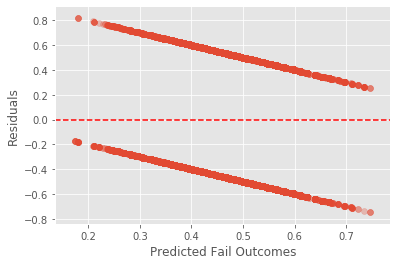

In [98]:
fig, ax = plt.subplots()
predictions = logit_model.predict(X_const_l)
ax.scatter(predictions,
           y_l - predictions,
           alpha=0.3)
ax.axhline(0, color='r', ls='--')
ax.set_xlabel('Predicted Fail Outcomes')
ax.set_ylabel('Residuals');

In [101]:
from scipy import stats

Text(0.5, 1.0, 'QQ Plot vs Normal dist for Prestige Residuals')

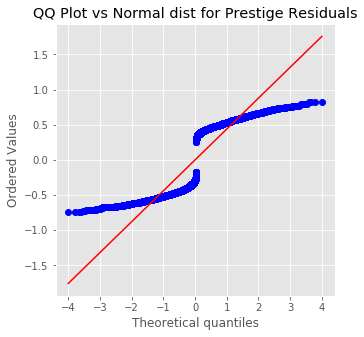

In [102]:
fig, ax = plt.subplots(figsize=((5, 5)))
predictions = logit_model.predict(X_const_l)
stats.probplot(y_l - predictions, plot=ax);
ax.set_title("QQ Plot vs Normal dist for Prestige Residuals")

In [35]:
model_rf = RandomForestClassifier(criterion = 'gini', n_estimators = 200, max_features = 0.25, 
                                    oob_score = True, bootstrap = True,min_samples_leaf= 4,
                                    min_samples_split= 2, random_state = 42, n_jobs = -1)

In [48]:
modelfit(model_rf, X_train,y_train, performCV=True, printFeatureImportance=False, cv_folds=5);


Model Report
Recall (Train) : 0.9016
AUC Score (Train): 0.970964
CV Score : Mean - 0.7656222 | Std - 0.003067165 | Min - 0.7601002 | Max - 0.7695035


In [38]:
model_rf_2 = RandomForestClassifier(criterion = 'gini', n_estimators = 200, max_features = 0.25, 
                                    oob_score = True, bootstrap = True,min_samples_leaf= 50,
                                    min_samples_split= 220, random_state = 42, n_jobs = -1)

In [51]:
modelfit(model_rf_2, X_train,y_train, performCV=True, printFeatureImportance=False, cv_folds=5);


Model Report
Recall (Train) : 0.6528
AUC Score (Train): 0.785633
CV Score : Mean - 0.7585926 | Std - 0.003659808 | Min - 0.7529921 | Max - 0.7623641


In [133]:
model_rf_3 = RandomForestClassifier(criterion = 'gini', n_estimators = 500, max_features = 0.25, 
                                    oob_score = True, bootstrap = True,min_samples_leaf= 4,
                                    min_samples_split= 2, random_state = 42, n_jobs = -1)

In [134]:
modelfit(model_rf_3, X_train,y_train, performCV=True, printFeatureImportance=False, cv_folds=5);


Model Report
Recall (Train) : 0.9046
AUC Score (Train): 0.971575
CV Score : Mean - 0.766645 | Std - 0.003248356 | Min - 0.7609081 | Max - 0.7709334


In [172]:
np.sqrt(len(X_train.columns))

10.344080432788601

In [174]:
rf_model_params = {
    'n_estimators': [100,200,500], # how many estimators is helpful?
    'max_features': ['sqrt', 0.25,.50,None], # how many features? 
#     'min_samples_split': [5, 10, 50],        
#     'min_samples_leaf': [5, 10, 50],
#    'max_depth': [3, None],
    'bootstrap': [True],    
    'random_state': [42]}

In [175]:
rf_model = RandomForestClassifier()


In [176]:
clf = GridSearchCV(rf_model, rf_model_params, cv=3,n_jobs = -1 , verbose = True)


In [177]:
model = clf.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  2.8min finished


In [178]:
pprint(model.best_estimator_.get_params())

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 0.5,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [180]:
model_rf_4 = RandomForestClassifier(criterion = 'gini', n_estimators = 500, max_features = 0.5, 
                                    oob_score = True, bootstrap = True,min_samples_leaf= 1,
                                    min_samples_split= 2, random_state = 42, n_jobs = -1)

In [181]:
modelfit(model_rf_4, X_train,y_train, performCV=True, printFeatureImportance=False, cv_folds=5);


Model Report
Recall (Train) : 0.9994
AUC Score (Train): 1.000000
CV Score : Mean - 0.7556419 | Std - 0.002666478 | Min - 0.7512996 | Max - 0.7596329


In [182]:
rf_model_params = {
    'n_estimators': [500,600, 700], # how many estimators is helpful?
    'max_features': [0.25,.50], # how many features? 
    'min_samples_split': [5, 10, 50],        
    'min_samples_leaf': [5, 10, 50],
   'max_depth': [3, None],
    'bootstrap': [True],    
    'random_state': [42]}

In [183]:
clf = GridSearchCV(rf_model, rf_model_params, cv=3,n_jobs = -1 , verbose = True)


In [184]:
model = clf.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed: 19.5min finished


In [185]:
pprint(model.best_estimator_.get_params())

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 0.25,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 5,
 'min_samples_split': 50,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [186]:
model_rf_5 = RandomForestClassifier(criterion = 'gini', n_estimators = 500, max_features = 0.25, 
                                    bootstrap = True,min_samples_leaf= 5,
                                    min_samples_split= 50, random_state = 42, n_jobs = -1)

In [187]:
modelfit(model_rf_5, X_train,y_train, performCV=True, printFeatureImportance=False, cv_folds=5);


Model Report
Recall (Train) : 0.7481
AUC Score (Train): 0.876831
CV Score : Mean - 0.7687839 | Std - 0.003981757 | Min - 0.7622472 | Max - 0.7731377


In [188]:
gb_model_params = {
    'n_estimators': [200,400,600], # how many estimators is helpful?
    'learning_rate': [0.1, 0.05, 0.02],
    'max_features': ['sqrt', 0.25,.50], # how many features? 

#     'max_features': ['sqrt', 0.25,.50,None], # how many features? 
#     'min_samples_split': [1,5, 10, 50],        
#     'min_samples_leaf': [1,5, 10, 50],
#    'max_depth': [3, 6, None],    
    'random_state': [42]}

In [189]:
gb_model = GradientBoostingClassifier()


In [190]:
clf = GridSearchCV(gb_model, gb_model_params, cv=3,n_jobs = -1 , verbose = True)


In [191]:
model = clf.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  1.3min finished


In [192]:
pprint(model.best_estimator_.get_params())

{'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 400,
 'n_iter_no_change': None,
 'presort': 'auto',
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


In [194]:
model_gb_3 = GradientBoostingClassifier(n_estimators = 400, learning_rate = 0.1
                                      ,min_samples_split = 2
                                      ,min_samples_leaf = 1
                                      ,max_depth = 3
                                      ,max_features = 'sqrt'
                                      ,subsample = 1
                                      , random_state = 42
                                     )

In [195]:
modelfit(model_gb_3, X_train,y_train, performCV=True, printFeatureImportance=False, cv_folds=5);


Model Report
Recall (Train) : 0.6967
AUC Score (Train): 0.811685
CV Score : Mean - 0.7767878 | Std - 0.001504218 | Min - 0.7748002 | Max - 0.7793014


In [197]:
gb_model_params = {
    'n_estimators': [400], # how many estimators is helpful?
    'learning_rate': [0.1, .2],
    'max_features': ['sqrt'], # how many features? 


    'min_samples_split': [5, 10, 50,100],        
    'min_samples_leaf': [5, 10, 50,100],
    'max_depth': [3, 6, 9, None],    
    'random_state': [42]}

In [198]:
clf = GridSearchCV(gb_model, gb_model_params, cv=3,n_jobs = -1 , verbose = True)


In [199]:
model = clf.fit(X_train, y_train)

Fitting 3 folds for each of 128 candidates, totalling 384 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 384 out of 384 | elapsed: 17.8min finished


In [200]:
pprint(model.best_estimator_.get_params())

{'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.2,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 100,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 400,
 'n_iter_no_change': None,
 'presort': 'auto',
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


In [201]:
model_gb_4 = GradientBoostingClassifier(n_estimators = 400, learning_rate = 0.2
                                      ,min_samples_split = 5
                                      ,min_samples_leaf = 100
                                      ,max_depth = 3
                                      ,max_features = 'sqrt'
                                      ,subsample = 1
                                      , random_state = 42
                                     )

In [202]:
modelfit(model_gb_4, X_train,y_train, performCV=True, printFeatureImportance=False, cv_folds=5);


Model Report
Recall (Train) : 0.7058
AUC Score (Train): 0.815624
CV Score : Mean - 0.7772973 | Std - 0.001933914 | Min - 0.7744788 | Max - 0.779916


In [40]:
model_gb = GradientBoostingClassifier(n_estimators = 200, learning_rate = 0.1, random_state = 42)

In [50]:
modelfit(model_gb, X_train,y_train, performCV=True, printFeatureImportance=False, cv_folds=5);


Model Report
Recall (Train) : 0.6898
AUC Score (Train): 0.805262
CV Score : Mean - 0.7752534 | Std - 0.002236932 | Min - 0.7717958 | Max - 0.7780934


In [42]:
model_gb_2 = GradientBoostingClassifier(n_estimators = 200, learning_rate = 0.1
                                      ,min_samples_split = 220
                                      ,min_samples_leaf = 50
                                      ,max_depth = 6
                                      ,max_features = 'sqrt'
                                      ,subsample = 0.8
                                      , random_state = 42
                                     )

In [52]:
modelfit(model_gb_2, X_train,y_train, performCV=True, printFeatureImportance=False, cv_folds=5);


Model Report
Recall (Train) : 0.718
AUC Score (Train): 0.831860
CV Score : Mean - 0.7768162 | Std - 0.004703998 | Min - 0.7700476 | Max - 0.7831705


In [ ]:
model_params = {
    'n_estimators': [10, 50, 100, 200],
    'max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0], #learning rate
    'min_samples_split': [2, 4, 6],        
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],    
    'random_state': [42]}

In [ ]:
clf = GridSearchCV(rf_model, model_params, cv=5, n_jobs = -1 , verbose = True)


In [ ]:
model = clf.fit(X_train_no_w, y_train_no_w)

In [ ]:

pprint(model.best_estimator_.get_params())

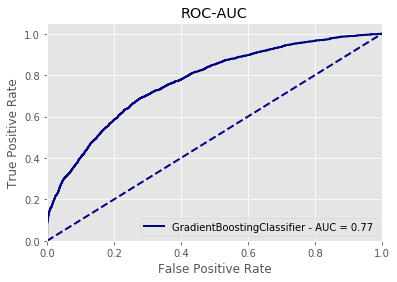

'Train Accuracy: 0.75. Test Accuracy: 0.70. Precision: 0.71. Recall: 0.68. AUC: 0.77'

In [225]:
get_scores(GradientBoostingClassifier, X_train, X_test, y_train, y_test, color = 'navy', n_estimators = 200, learning_rate = 0.1
                                      ,min_samples_split = 220
                                      ,min_samples_leaf = 50
                                      ,max_depth = 6
                                      ,max_features = 'sqrt'
                                      ,subsample = 0.8
                                      , random_state = 42)

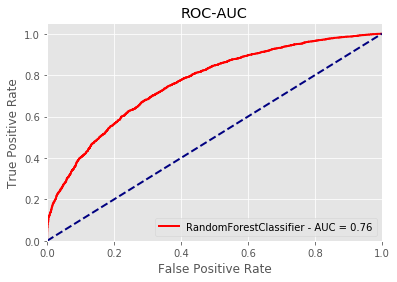

'Train Accuracy: 0.79. Test Accuracy: 0.69. OOB: 0.70. Precision: 0.70. Recall: 0.63. AUC: 0.76'

In [226]:
get_scores(RandomForestClassifier, X_train, X_test, y_train, y_test, color = 'red', criterion = 'gini', n_estimators = 500, max_features = 0.25, 
                                    bootstrap = True,min_samples_leaf= 5, oob_score = True,
                                    min_samples_split= 50, random_state = 42, n_jobs = -1)

In [214]:
X_train_l.shape

(22436, 104)

In [215]:
y_train_l.shape

(22436,)

In [216]:
X_test_l.shape

(7479, 104)

/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


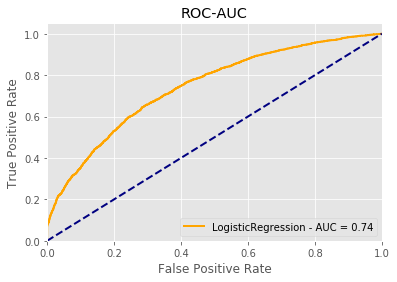

'Train Accuracy: 0.68. Test Accuracy: 0.68. Precision: 0.68. Recall: 0.65. AUC: 0.74'

In [224]:
get_scores(LogisticRegression, X_train_l, X_test_l, y_train_l, y_test_l, color = 'orange')

In [230]:
from src.modeling_script import feature_importance

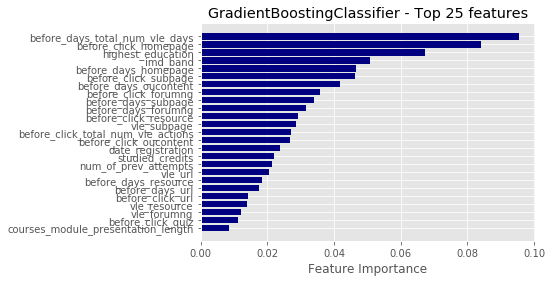

In [231]:
feature_importance(GradientBoostingClassifier, X_train, X_test, y_train, y_test, color = 'navy', n_estimators = 200, learning_rate = 0.1
                                      ,min_samples_split = 220
                                      ,min_samples_leaf = 50
                                      ,max_depth = 6
                                      ,max_features = 'sqrt'
                                      ,subsample = 0.8
                                      , random_state = 42)

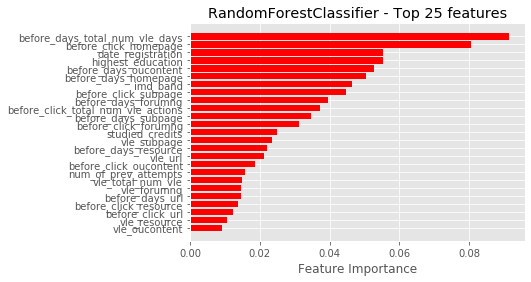

In [219]:
feature_importance(RandomForestClassifier, X_train, X_test, y_train, y_test, color = 'red', criterion = 'gini', n_estimators = 500, max_features = 0.25, 
                                    bootstrap = True,min_samples_leaf= 5, oob_score = True,
                                    min_samples_split= 50, random_state = 42, n_jobs = -1)